# Introduction
### **Title:** *Simulation of an Infectious Process on Graphs*


## Specific Objectives of the SIRS Epidemic Model Simulation Project
1. **Understand the Dynamics of the SIRS Model:** To gain a comprehensive understanding of the SIRS epidemic model, focusing on the transitions between susceptible, infected, and recovered states in a population.
2. **Graph-Based Simulation:** To implement a simulation of the SIRS model on an undirected graph where nodes represent individuals and edges represent the contact between them, capturing the social structure of the population.
3. **Investigate the Impact of Transition Probabilities:**    * To explore how varying the transition probabilities (δ for susceptible to infected, γ for infected to recovered, and β for recovered to susceptible) affects the spread of the epidemic through the network.
    * To identify critical thresholds for these probabilities that significantly alter the course of the epidemic.
4. **Analyze the Role of Network Structure:** To analyze how different underlying graph structures (e.g., random graphs, scale-free networks, small-world networks) influence the dynamics of the epidemic spread.
5. **Comparison with Real-World Data:** To compare the outcomes of the simulation with real-world data on epidemic spreads (where available) to evaluate the model's realism and applicability.
6. **Parameter Sensitivity Analysis:** To conduct a sensitivity analysis on the model parameters (δ, γ, β) to understand their influence on the epidemic's outcomes and identify any non-linear behaviors or tipping points.
7. **Optimization of Control Strategies:** To use the simulation to test hypothetical control strategies (e.g., increasing the recovery rate, temporary immunity) and assess their effectiveness in containing the epidemic.
8. **Develop a User-Friendly Simulation Tool:** To create an interactive simulation tool that allows users to modify parameters (δ, γ, β) and graph structures, enabling educators, students, and researchers to explore epidemic dynamics intuitively..





## Methodology and Implementation
### Introduction to the SIRS Model
The *SIRS* model is an epidemiological model used to simulate how an infectious disease spreads through a population. The model divides the population into three compartments or states:
1. **Susceptible (S):** Individuals in this state are healthy but can become infected if they come into contact with an infected individual.
2. **Infected (I):** Individuals in this state are currently infected with the disease and can transmit it to susceptible individuals.
3. **Recovered (R):** Individuals in this state have recovered from the disease and have gained immunity, making them temporarily resistant to reinfection.
The transitions between these states are governed by three probabilities:
* **δ (Delta):** The probability of a susceptible individual becoming infected upon contact with an infected individual. This transition represents the spread of the disease.
* **γ (Gamma):** The probability of an infected individual recovering and moving into the recovered state. This transition represents the process of recovery.
* **β (Beta):** The probability of a recovered individual losing immunity and becoming susceptible again. This transition models the waning immunity over time, making individuals susceptible to the disease once more.







### Setup the Environment
We will use:
* **networkx:** For creating and manipulating complex networks.
* **numpy:** For efficient numerical computations.
* **matplotlib.pyplot:** For plotting the graph and visualizing the data.
* **FuncAnimation:** For animating the spreading of the desease.
*  **HTML:** For displaying the animation.
*  **pandas:** For data manipulation.
*  **os:** To have access to the data.
*  **Pool:** For parallel processing.
*  **jit:** The use of Numba's JIT compilation to speed up the simulation loop.
*  **random:**
*  **display:**
*  **clear_output:**
*  **widgets:** To create a GUI for the initial conditions

In [56]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import pandas as pd
import os
from multiprocessing import Pool
from numba import jit
import random
from IPython.display import display, clear_output
import ipywidgets as widgets

### Create a Random Graph
Random graphs can approximate the complex and often unpredictable nature of real-world social interactions since they help simulate a wide variety of network structures, ranging from highly connected to sparsely connected networks, hence capturing the heterogeneity seen in real populations.
While **Erdős-Rényi (ER)** graphs are useful for their simplicity and for modeling random interactions within a population since they lead to a homogeneous mixing pattern, however, they are not the best representation forSIRS models (especially when we're considering recovery and the possibility of reinfection), because real-world social networks are often heterogeneous, with variations in node degree (i.e., *some individuals have more contacts than others*), which can significantly affect disease spread and recovery dynamics.

Instead we will use some other alternatives like:
1. **Small-World Networks** Capture the clustering and short path lengths observed in many social networks.
2. **Scale-Free Networks:** These networks include a few highly connected nodes that can play a significant role in disease transmission and are more representative of social structures.
3. **Dynamic Networks:** Incorporate changes in network structure over time, allowing for the simulation of contact formation and dissolution.
4. **Networks with Community Structure:** Models that explicitly include community structure can better simulate the spread of diseases within and between communities, reflecting the complexity of real-world interactions.



### Small-World Network VS Scale-Free Networks
For this example, choose ***1*** if you want to generate a **small-world network** using the **Watts-Strogatz model**, and ***2*** if you want to generate a **scale-free network** using the **Barabási–Albert model**.

#### Small-World Networks
* **Characterized by** high clustering and short average path lengths.
* **Initialization:** Distributing initial infected nodes randomly or targeting specific nodes can have varying impacts due to the network's clustering properties and short path lengths, which facilitate rapid spreading to most of the network.
* **Disease Spread:** The high clustering can lead to rapid initial outbreaks, especially if the initial infected nodes are well-connected or if the path lengths allow for quick disease transmission across the network.



#### Scale-Free Networks
* **Characterized by** a power-law degree distribution, with a few nodes having very high degrees (hubs) and many nodes with low degrees.
* **Initialization:** The presence of hubs or highly connected nodes can significantly influence disease spread. Initiating the infection in high-degree nodes can lead to faster and more widespread outbreaks compared to starting in low-degree nodes.
* **Disease Spread:** The heterogeneity in node connectivity leads to non-uniform spreading patterns, with disease transmission potentially being very efficient if it reaches the hubs.



Enter 1 for a small-world network, or 2 for a scale-free network:  2


Scale-free network generated.


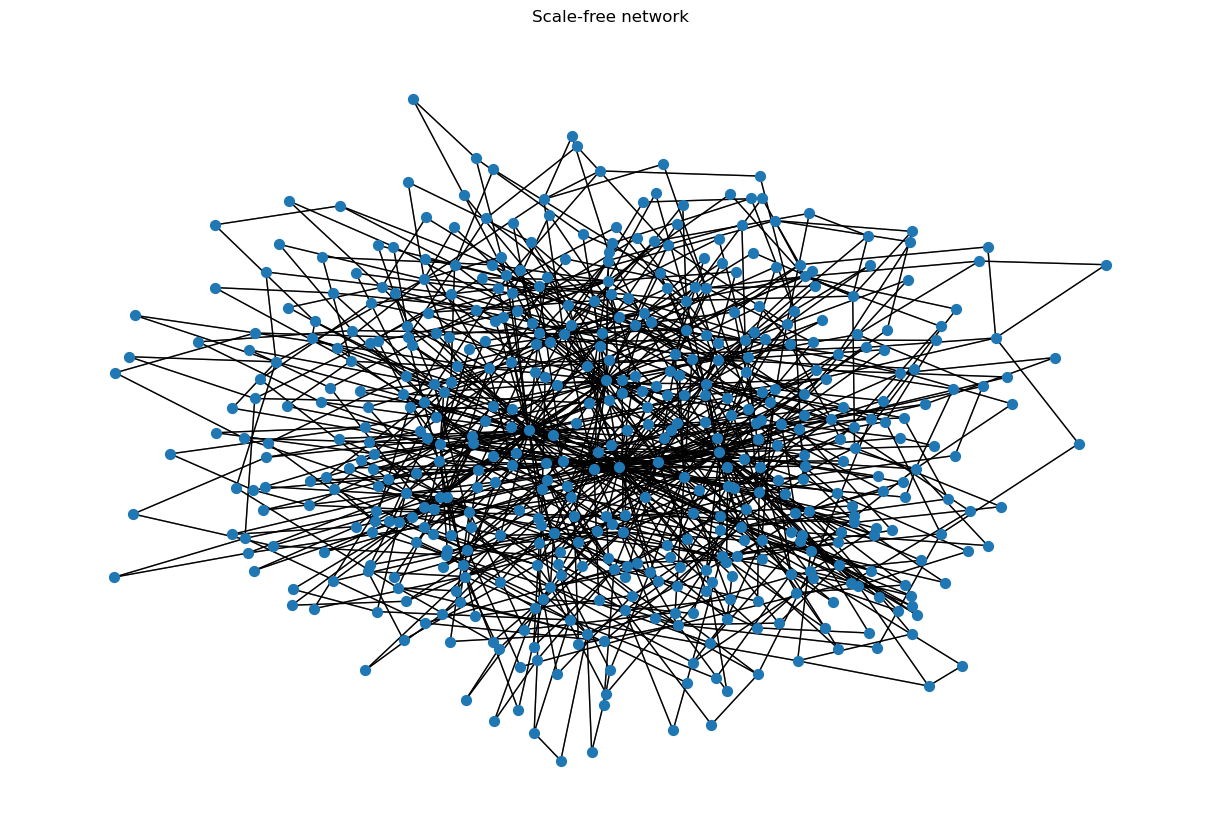

In [31]:
# Prompt the user to choose the type of network
choice = input("Enter 1 for a small-world network, or 2 for a scale-free network: ")

num_nodes = 500  # number of nodes

if choice == '1':
    # Parameters for the small-world network
    k = 4    # each node is connected to k nearest neighbors in ring topology
    p = 0.05 # the probability of rewiring each edge
    G = nx.connected_watts_strogatz_graph(num_nodes, k, p)
    title = "Small-world network"
    print("Small-world network generated.")
elif choice == '2':
    # Parameters for the scale-free network
    G = nx.barabasi_albert_graph(num_nodes, 2)
    title = "Scale-free network"
    print("Scale-free network generated.")
else:
    print("Invalid choice. Please enter 1 or 2.")
    G = None

if G is not None:
    
    pos = nx.spring_layout(G)  # positions for all nodes
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=False, node_size=50)
    nx.draw_networkx_edges(G, pos, alpha=0.4)
    plt.title(title)
    plt.show()

In [32]:
def visualize_network(G, title):
    """
    visualize the network with states.

    Parameters:
    - G: The networkx graph object with node attributes 'state'.
    - title: the title of the plot.
    """
    color_map = {'S': 'lightblue', 'I': 'red', 'R': 'green'}
    node_colors = [color_map[G.nodes[node]['state']] for node in G.nodes()]
    
    plt.figure(figsize=(10, 8))
    nx.draw(G, node_color=node_colors, with_labels=False, node_size=50)
    plt.title(title)
    plt.show()

### Simulate the SIRS Process
In each time step, the following transitions can occur for each node based on the model's rules and the probabilities δ (susceptible to infected), γ (infected to recovered) and β (recovered to susceptible).
1. **Susceptible to Infected (δ):** A susceptible node becomes infected with probability δ if it has at least one infected neighbor.
2. **Infected to Recovered (γ):** An infected node transitions to the recovered state with probability γ.
3. **Recovered to Susceptible (β):** A recovered node becomes susceptible again with probability β.

In [33]:
def simulate_SIRS_step(G, delta, gamma, beta):
    """
    Simulate one time step of the SIRS model and update the graph.

    Parameters:
    - graph: The networkx graph object with node attributes 'state'.
    - delta: Probability of S->I transition.
    - gamma: Probability of I->R transition.
    - beta: Probability of R->S transition.

    Returns:
    - None: The graph object is modified in place.
    """
    new_states = {} # Dictionary to hold new states
    
    for node in G.nodes():
        state = G.nodes[node]['state']
        neighbors = list(G.neighbors(node))
        infected_neighbors = sum(G.nodes[neighbor]['state'] == 'I' for neighbor in neighbors)
        
        # Susceptible to Infected transition
        if state == 'S' and infected_neighbors > 0 and np.random.random() < delta:
                new_states[node] = 'I'
        
        # Infected to Recovered transition
        if state == 'I' and np.random.random() < gamma:
                new_states[node] = 'R'
                
        # Recovered to Susceptible transition
        if state == 'R' and np.random.random() < beta:
                new_states[node] = 'S'
    
    # Update the states in the graph
    nx.set_node_attributes(G, new_states, 'state')

### Run the simulation
The simulation runs for a predetermined number of iterations, representing time steps in our model. At each step, the state of each individual in the network is updated based on their current state, the states of their neighbors, and the transition probabilities.
This allows us to study the effects of different parameter values on the epidemic's behavior.

#### Initialize the SIRS Model and plot the network
Let's assign each node a state: *Susceptible (S)*, *Infected (I)*, or *Recovered (R)*. 
Initially, let's start with a small fraction of infected individuals and the rest susceptible, and plot some random simulations below

In [38]:
# Simulation parameters
delta = 0.8 # Probability of S->I transition.
gamma = 0.1 # Probability of I->R transition.
beta = 0.2 # Probability of R->S transition.
infected_ratio = 0.01  # Initial fraction of infected individuals
num_simulations = 50 # Number of simulations
num_steps = 40 # Number of steps

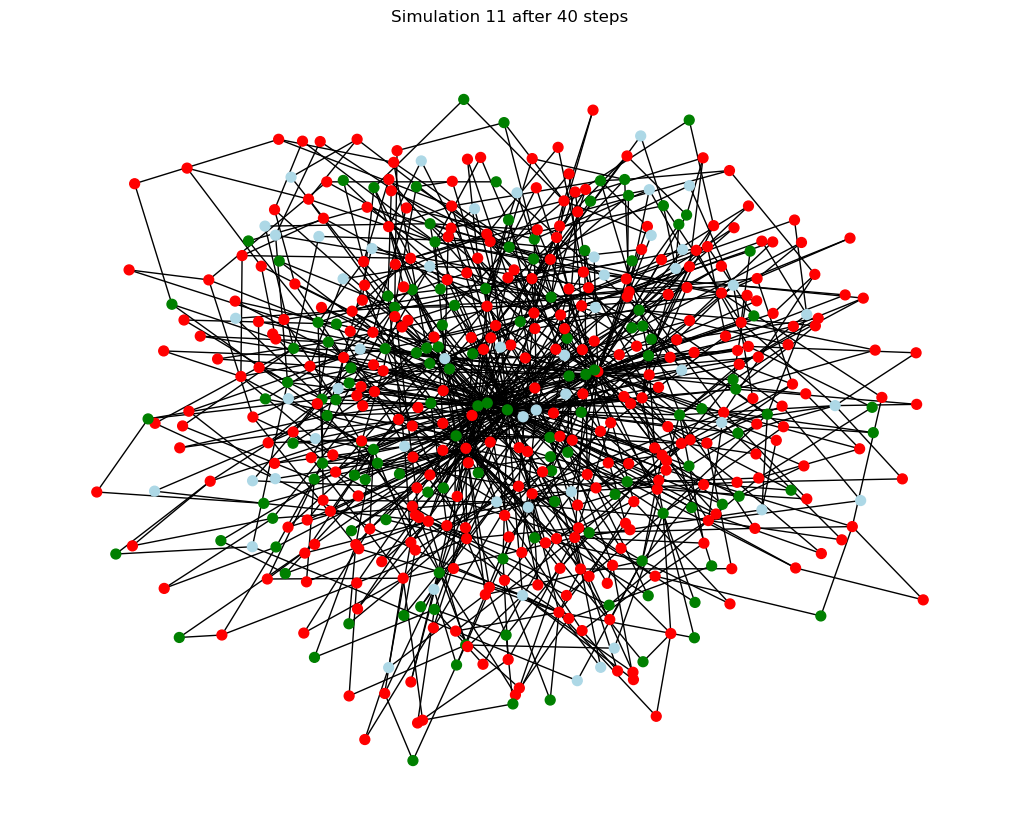

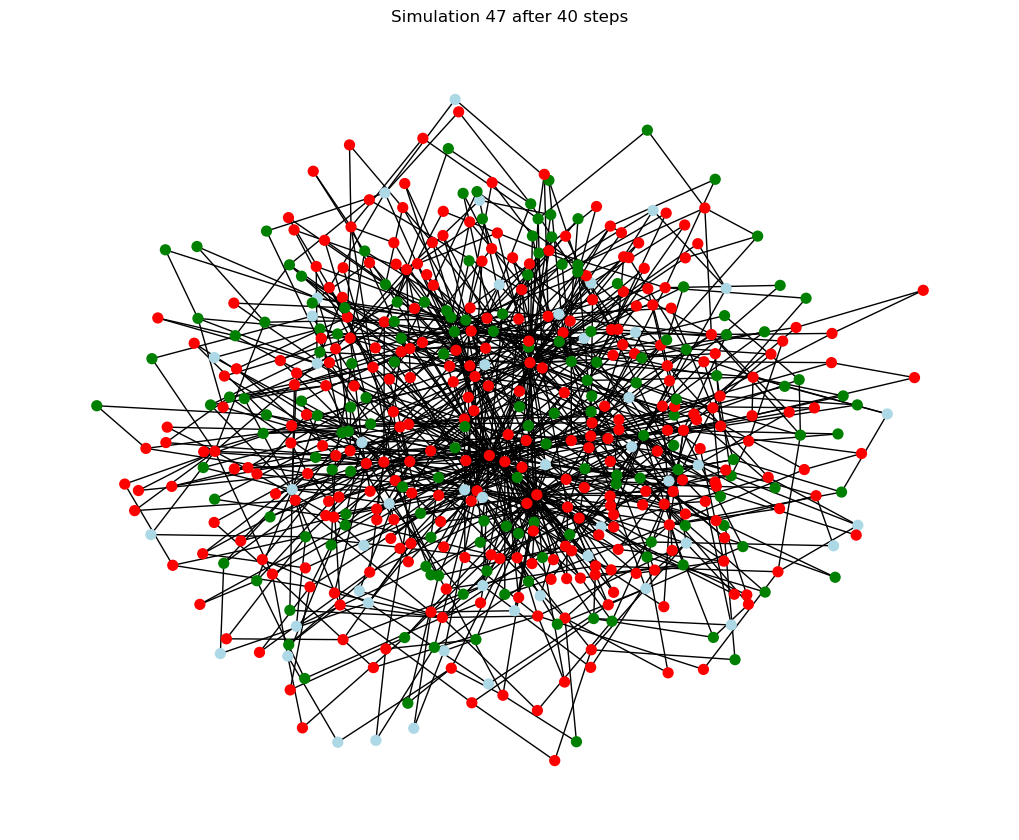

In [39]:
# Initialize arrays to collect simulation data
all_S = np.zeros((num_simulations, num_steps))
all_I = np.zeros((num_simulations, num_steps))
all_R = np.zeros((num_simulations, num_steps))

# Select 2 random simulations to plot
simulations_to_plot = random.sample(range(num_simulations), 2)
plot_counter = 0

# Run multiple simulations
for simulation in range(num_simulations):
    # Use a copy of the graph for each simulation to prevent modifying the original
    G_sim = G.copy()
    
    # Initialize the nodes' state
    for node in G_sim.nodes():
        G_sim.nodes[node]['state'] = 'S'
    initial_infecteds = random.sample(list(G_sim.nodes()), int(len(G_sim) * infected_ratio))
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    # We can Consider targeting high-degree nodes in scale-free networks for initial infection, hence a faster spread.
    if "scale-free" in str(type(G)):
        # Infect high-degree nodes instead of random selection
        degrees = dict(G.degree())
        high_degree_nodes = sorted(degrees, key=degrees.get, reverse=True)[:initial_infected]
        for node in high_degree_nodes:
            G.nodes[node]['state'] = 'I'
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    for node in initial_infecteds:
        G_sim.nodes[node]['state'] = 'I'

    # Run the simulation
    for step in range(num_steps):
        simulate_SIRS_step(G_sim, delta, gamma, beta)  # Implement this function based on the rules of SIRS model
        
        # Count the number of S, I, R individuals and store the counts
        states = nx.get_node_attributes(G_sim, 'state')
        all_S[simulation, step] = sum(state == 'S' for state in states.values())
        all_I[simulation, step] = sum(state == 'I' for state in states.values())
        all_R[simulation, step] = sum(state == 'R' for state in states.values())

    # Plot the network for selected simulations
    if simulation in simulations_to_plot:
        visualize_network(G_sim, f'Simulation {simulation + 1} after {num_steps} steps')
        plot_counter += 1
        if plot_counter >= 2:  # Limit to 2 plots
            break

Let's now plot the I, S, and R and find the equilibrium state

Equilibrium reached at step 19
Mean and std at equilibrium (step 19):
Mean S: 38.08, Std S: 11.42
Mean I: 293.96, Std I: 74.87
Mean R: 137.96, Std R: 35.93


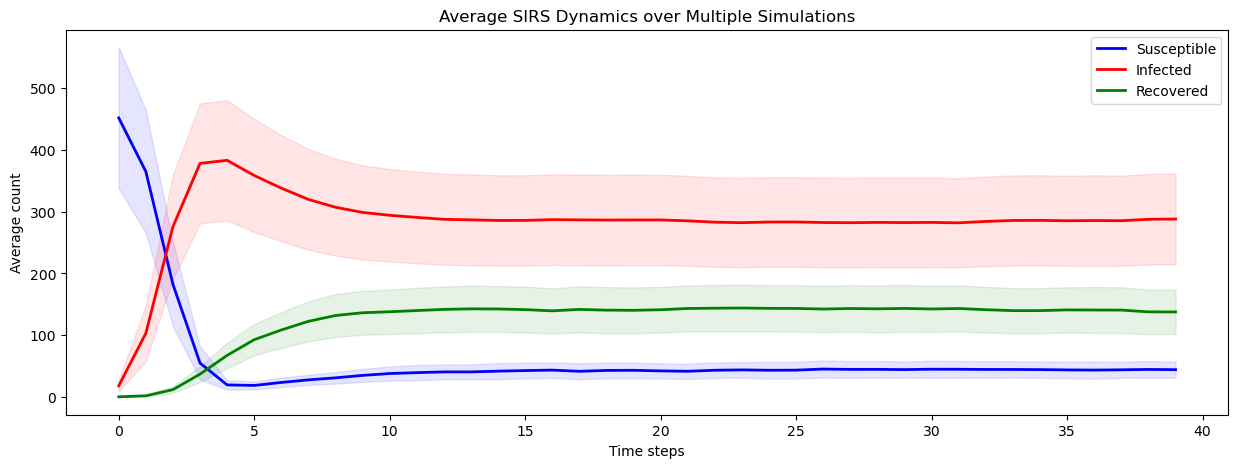

In [40]:
# Calculate global moving averages and standard deviations
global_moving_avg_S = np.mean(all_S, axis=0)
global_moving_avg_I = np.mean(all_I, axis=0)
global_moving_avg_R = np.mean(all_R, axis=0)
global_moving_std_S = np.std(all_S, axis=0)
global_moving_std_I = np.std(all_I, axis=0)
global_moving_std_R = np.std(all_R, axis=0)

window_size = 5
threshold = 0.05
consecutive_steps_for_equilibrium = 5

# Adjust the loop for checking equilibrium condition
for i in range(1, len(global_moving_avg_I)):
    epsilon = 1e-10
    if (np.abs(global_moving_avg_I[i] - global_moving_avg_I[i-1]) / (global_moving_avg_I[i-1] + epsilon) < threshold):
        consecutive_steps_below_threshold += 1
        if consecutive_steps_below_threshold >= consecutive_steps_for_equilibrium:
            equilibrium_step = i + window_size // 2  # Adjust for the window size effect
            break
    else:
        consecutive_steps_below_threshold = 0

# Check if an equilibrium step was found and print mean and std
if equilibrium_step is not None:
    print(f"Equilibrium reached at step {equilibrium_step + window_size}")
    eq_step_index = equilibrium_step - (window_size - 1)
    print(f"Mean and std at equilibrium (step {equilibrium_step + window_size}):")
else:
    print("Equilibrium state was not reached within the given time frame")
    eq_step_index = -1  # Use the last step's index
    print(f"Mean and std at the last step ({num_steps}):")

# Print global means and standard deviations at equilibrium or the last step
print(f"Mean S: {global_moving_avg_S[eq_step_index]:.2f}, Std S: {global_moving_std_S[eq_step_index]:.2f}")
print(f"Mean I: {global_moving_avg_I[eq_step_index]:.2f}, Std I: {global_moving_std_I[eq_step_index]:.2f}")
print(f"Mean R: {global_moving_avg_R[eq_step_index]:.2f}, Std R: {global_moving_std_R[eq_step_index]:.2f}")

# Plotting I, S, and R
plt.figure(figsize=(15, 5))

plt.fill_between(range(num_steps), global_moving_avg_S - global_moving_std_S, global_moving_avg_S + global_moving_std_S, color='blue', alpha=0.1)
plt.plot(range(num_steps), global_moving_avg_S, label='Susceptible', color='blue', linewidth=2)

plt.fill_between(range(num_steps), global_moving_avg_I - global_moving_std_I, global_moving_avg_I + global_moving_std_I, color='red', alpha=0.1)
plt.plot(range(num_steps), global_moving_avg_I, label='Infected', color='red', linewidth=2)

plt.fill_between(range(num_steps), global_moving_avg_R - global_moving_std_R, global_moving_avg_R + global_moving_std_R, color='green', alpha=0.1)
plt.plot(range(num_steps), global_moving_avg_R, label='Recovered', color='green', linewidth=2)

plt.xlabel('Time steps')
plt.ylabel('Average count')
plt.title('Average SIRS Dynamics over Multiple Simulations')
plt.legend()
plt.show()

### Heterogeneous Diffusion
1. **Modify Transition Probabilities:** Change the model to have heterogeneous transmission probabilities based on the number of infected neighbors.2. **Simulation Adjustments:** Adjust the simulation code to incorporate these new rules and observe the impact on the epidemic spread.




### Graph Mining with R-Mat
1. **Integrate R-Mat:** Use the R-Mat algorithm for graph generation and simulate the epidemic on these graphs.
2. **Analysis:** Analyze how the structure generated by R-Mat affects the spread as compared to other models


### Real-World Data and Graph Generators
1. **Utilize Graph Generators:** Implement graph generators like Darwini or Datasynth to create graphs based on real-world data.
2. **Comparison:** Compare the simulation results across the different graph types, including real-world data-informed graphs.



### C++ Implementation with EpiFire
1. **C++ Simulation:** Write a basic C++ code to simulate the epidemic using the EpiFire library.
2. **Interpretation:** Compare the performance and results of the C++ simulation with the Python version.




### Fixed graph 
For this example, we'll use a *simple lattice network*, which is a type of fixed graph with a regular structure. 
* In a lattice network, each node is connected to its nearest neighbors in a grid-like pattern.
* It's a 2D lattice network. Each node will be connected to its four neighbors (up, down, left, right), except for nodes on the edges of the grid, which will have fewer neighbors (it's like a matrix).


In [84]:
# Simulation parameters
delta = 0.7  # Probability of S->I transition
gamma = 0.2 # Probability of I->R transition
beta = 0.4  # Probability of R->S transition
num_steps = 100  # Number of steps in each simulation
num_simulations = 15  # Number of simulations to run
infected_ratio = 0.0001 # Initial fraction of infected individuals
boundary_condition = 'non-fixed'  # default value

In [42]:
# Define the colors: blue for Susceptible, red for Infected, green for Recovered
def colors_grid():
    cmap = plt.cm.colors.ListedColormap(['blue', 'red', 'green'])
    norm = plt.cm.colors.BoundaryNorm([-1, 0, 1, 2], cmap.N)
    return cmap, norm

In [47]:
# Function to plot the grid as separate squares with borders
def plot_grid(grid):
    # Create the figure and axes
    fig, ax = plt.subplots(figsize=(8, 8))

    cmap, norm = colors_grid()
    
    # Loop over the grid and plot each cell as a square with a border
    for (i, j), state in np.ndenumerate(grid):
        color = cmap(norm(state))
        square = plt.Rectangle((j-0.5, i-0.5), 1, 1, facecolor=color, edgecolor='white', linewidth=0)
        ax.add_patch(square)
    
    # Set the axis limits to show all squares
    ax.set_xlim(-0.5, grid.shape[1]-0.5)
    ax.set_ylim(-0.5, grid.shape[0]-0.5)
    
    # Hide the axis ticks and labels
    ax.axis('off')

    plt.show()

The user have 2 choices:
1. Plotting a **lattice network** (choice **1**)
2. Plotting a **matrix grid** (choice **2**)

Enter 1 for a 2D Lattice Network, or 2 for a matrix grid:  2


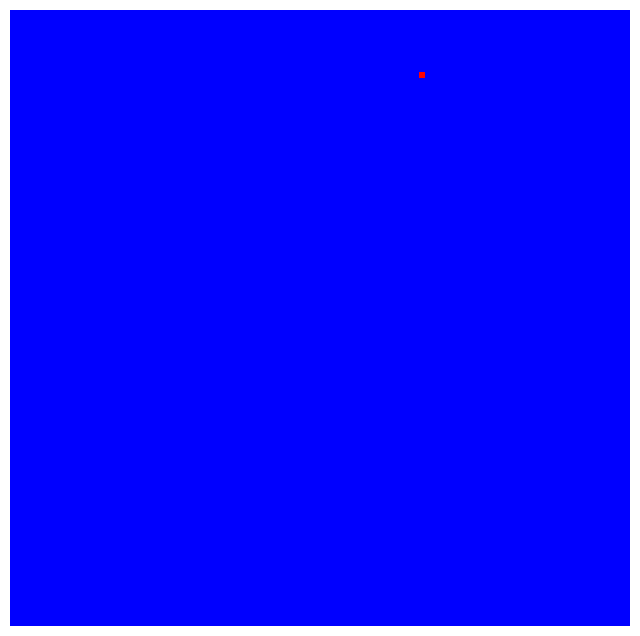

In [81]:
# Define dimensions of the lattice
width, height = 100,100

choice = input("Enter 1 for a 2D Lattice Network, or 2 for a matrix grid: ")

if choice == '1':
    # Create a 2D lattice graph
    G = nx.grid_2d_graph(width, height, periodic=False)
    
    # Convert node labels from 2D coordinates to integers
    G = nx.convert_node_labels_to_integers(G)
    
    # Create positions for each node for visualization
    pos = {node: (node % width, -(node // width)) for node in G.nodes()}

    nx.set_node_attributes(G, 'S', 'state')
        
    # Choose initial infected nodes
    initial_infecteds = np.random.choice(G.nodes(), size=int(G.number_of_nodes() * infected_ratio), replace=False)

    for i in initial_infecteds:
        G.nodes[i]['state'] = 'I'
    
    # Visualize the graph
    color_map = {'S': 'blue', 'I': 'red'}
    node_colors = [color_map[G.nodes[node]['state']] for node in G.nodes()]
    
    # Draw the graph
    nx.draw(G, pos, with_labels=False, node_size=50, node_color=node_colors)
    plt.title('2D Lattice Network')
    plt.show()

elif choice == '2':
    # Initialize the grid: -1 for Susceptible, 0 for Infected, 1 for Recovered
    grid = np.full((height, width), -1)  # Start with all susceptible
    # Infect a random fraction of the grid
    num_infected = int(width * height * infected_ratio)
    infected_indices = np.random.choice(width * height, num_infected, replace=False)
    grid.flat[infected_indices] = 0  # Set infected

    # Plot the initialized grid
    plot_grid(grid)

else:
    print("Invalid choice. Please enter 1 or 2.")
    G = None

### SIRS Model Simulation on a Matrix Grid
In this section, we are adapting the SIRS (Susceptible-Infected-Recovered-Susceptible) epidemic model to simulate on a matrix grid. The matrix grid approach provides a simplified and computationally efficient representation of the network model where individuals (or nodes) and their states are represented as elements within a 2D array. This contrasts with a more complex graph-based approach that requires handling individual nodes and edges.
* We represent the states within a numpy array with the following values:
    * **-1:** Susceptible
    * **0:** Infected
    * **1:** Recovered
* The function *simulate_epidemic_step* iterates over each element in the array (each individual), checks the states of its neighbors, applies the SIRS transition rules, and returns the updated grid

In [63]:
@jit(nopython=True)
def simulate_epidemic_step(grid, delta, gamma, beta, boundary_condition, model):
    """
    Simulate one step of an epidemic model (SIR, SIS, or SIRS) on a matrix grid.

    Parameters:
    - grid: numpy array representing the state of each cell (-1: Susceptible, 0: Infected, 1: Recovered)
    - delta: Probability of S->I transition
    - gamma: Probability of I->R transition (for SIR and SIRS) or I->S transition (for SIS)
    - model: Type of model to simulate ('SIR', 'SIS', or 'SIRS')
    - beta: Probability of R->S transition (used in SIR and SIRS models)
    - boundary_condition: Type of boundary condition ('fixed' or 'non-fixed')

    Returns:
    - A new grid representing the next state.
    """
    width, height = grid.shape
    new_grid = np.empty_like(grid)
    for i in range(height):
        for j in range(width):
            state = grid[i, j]
            infected_neighbors = 0
            neighbor_offsets = [(-1, 0), (1, 0), (0, -1), (0, 1)]
            for di, dj in neighbor_offsets:
                ni, nj = i + di, j + dj
                if boundary_condition != 'fixed':
                    ni, nj = ni % height, nj % width
                # Check bounds for fixed boundaries
                if 0 <= ni < height and 0 <= nj < width:
                    if grid[ni, nj] == 0:
                        infected_neighbors += 1
   
            # State transitions
            rand = np.random.random()  # Generate a random number once per cell for efficiency
            if state == -1 and infected_neighbors > 0 and rand < delta:
                new_grid[i, j] = 0  # S->I for SIR/SIRS/SIS
            elif state == 0 and rand < gamma:
                new_state = -1 if model == 'SIS' else 1  # I->R for SIR/SIRS, I->S for SIS
                new_grid[i, j] = new_state
            elif state == 1 and model == 'SIRS' and rand < beta:
                new_grid[i, j] = -1  # R->S for SIRS
            else:
                new_grid[i, j] = state
                
    return new_grid

### Running multiple simulations on fixed graphs
After defining the key parameters (probabilities, initial conditions etc...), let's run the simulations multiple times to observe the variability in the outcomes. This will help us understand the potential range of epidemic sizes and durations due to stochastic effects.
* Let's animate the spreading of the infection

In [64]:
# Function to update the plot for each frame
def update(frame, G_sim, states_history, ax, num_steps):
    ax.clear()
    # Retrieve the states from history
    states = states_history[frame]
    colors = ['blue' if state == 'S' else 'red' if state == 'I' else 'green' for state in states]
    nx.draw(G_sim, pos, node_color=colors, with_labels=False, ax=ax)
    ax.set_title(f"Step: {frame}/{num_steps}")

In [65]:
def update_matrix(frame, grid_history, ax):
    ax.clear()  # Clear the axis to draw the new frame
    current_grid = grid_history[frame]  # Get the current grid state from history
    
    # Define the colors: blue for Susceptible, red for Infected, green for Recovered
    cmap = plt.cm.colors.ListedColormap(['blue', 'red', 'green'])
    norm = plt.cm.colors.BoundaryNorm([-1, 0, 1, 2], cmap.N)
    
    # Use imshow to plot the grid efficiently
    ax.imshow(current_grid, cmap=cmap, norm=norm, extent=(-0.5, current_grid.shape[1]-0.5, -0.5, current_grid.shape[0]-0.5))

    # Hide the axis ticks and labels
    ax.axis('off')
    ax.set_title(f"Step: {frame}/{len(grid_history)}")

In [86]:
# Prepare to collect simulation results
all_I = np.zeros((num_simulations, num_steps))
all_S = np.zeros((num_simulations, num_steps))
all_R = np.zeros((num_simulations, num_steps))

# Select 3 random simulations to plot
simulations_to_plot = random.sample(range(num_simulations), 3)

# Run multiple simulations
for simulation in range(num_simulations):
    if choice == '1':
        G_sim = G.copy() # Reset the graph
        states_history = [] # Store states for each step

    else:
        grid_copy = np.copy(grid) 
        grid_history = [] # Store states for each step
    
    # Run the simulation
    for step in range(num_steps):
        if choice == '1':
            states = [G_sim.nodes[node]['state'] for node in G_sim.nodes()]
            states_history.append(states)  # Append current states to history
            
            all_S[simulation, step] = states.count('S')
            all_I[simulation, step] = states.count('I')
            all_R[simulation, step] = states.count('R')

            simulate_SIRS_step(G_sim, delta, gamma, beta)

        else:
            grid_history.append(np.copy(grid_copy))  # Store the updated state

            # Store the counts of S, I, R
            all_S[simulation, step] = np.count_nonzero(grid_copy == -1)
            all_I[simulation, step] = np.count_nonzero(grid_copy == 0)
            all_R[simulation, step] = np.count_nonzero(grid_copy == 1)

            grid_copy = simulate_epidemic_step(grid_copy, delta, gamma, beta, 'non-fixed', 'SIRS')  # Update grid state

    # Append the last state
    if choice == '1':
        states_history.append(states) 
    else:
        grid_history.append(np.copy(grid_copy))

    # Plot the network for selected simulations
    if simulation in simulations_to_plot:
        fig, ax = plt.subplots(figsize=(8, 8))
        if choice == '1':
            # Now create the animation for the current simulation
            ani = FuncAnimation(fig, update, frames=num_steps, fargs=(G_sim, states_history, ax, num_steps), interval=100, repeat=False)
            title = f'sirs_simulation_{simulation + 1}.mp4'
            
        else:
            ani = FuncAnimation(fig, update_matrix, frames=len(grid_history), fargs=(grid_history, ax), interval=100, repeat=False)
            title = f'sirs_simulation_grid_{simulation + 1}.mp4'
            
        # Display the animation
        plt.close(fig)  # Close the plot to prevent it from showing statically
        HTML(ani.to_jshtml())  # This will embed the animation in the notebook

        # Save the animation as a video file
        ani.save(title) 

Let's try to process the result next to get the mean and standard deviation for S, I, and R and find the equilibrium state.
* To ensure that the system has indeed reached an equilibrium state, we can modify the code to check for a consecutive number of time steps where the percentage change in the average number of infected, recovered and suspected individuals is below the threshold, rather than just a single time step.
* The moving average is used to smooth out short-term fluctuations and highlight longer-term trends in data.
* By smoothing out these fluctuations, we can more accurately determine when the system reaches an equilibrium state, which is characterized by the minimal change in the number of susceptible, infected, and recovered individuals over time.


The equilibrium state we are determining using global moving averages is a representation of the "average" behavior of the system across all simulations. While it may not reflect the precise dynamics of any single simulation at any given time, it gives a more general and statistically robust picture of the system's behavior.

In stochastic simulations like the SIRS model, individual runs can vary significantly due to the random nature of the transitions between states. By considering the moving average across multiple simulations:

* **You reduce the noise:** The moving average smooths out the randomness and fluctuations that might be present in individual simulations.

* **You get a better estimate of the expected behavior:** When you average across many simulations, you are essentially estimating the expected value of the system's state at any given time step, which can be a more reliable indicator of the system's behavior than any single run.

* **You assess the stability of the system:** The equilibrium detected in this way is not the *static equilibrium* where no more changes occur but rather a *dynamic equilibrium* where the system's state changes around a relatively stable average value.

However, there are a few problems we should keep in mind:

* **The chosen *threshold* and *window size*:** These parameters significantly influence the detection of equilibrium. If the *threshold* is too strict, we might not detect equilibrium even if the system is relatively stable and the *window size* affects how much the data is smoothed.

In summary, the equilibrium we are determining is a measure of when the system's behavior becomes stable and predictable on average, rather than an indication of when each simulation individually reaches a static state.

Equilibrium reached at step 93
Mean and std at equilibrium (step 93):
Mean S: 2040.48, Std S: 84.64
Mean I: 5325.41, Std I: 59.47
Mean R: 2634.11, Std R: 55.56


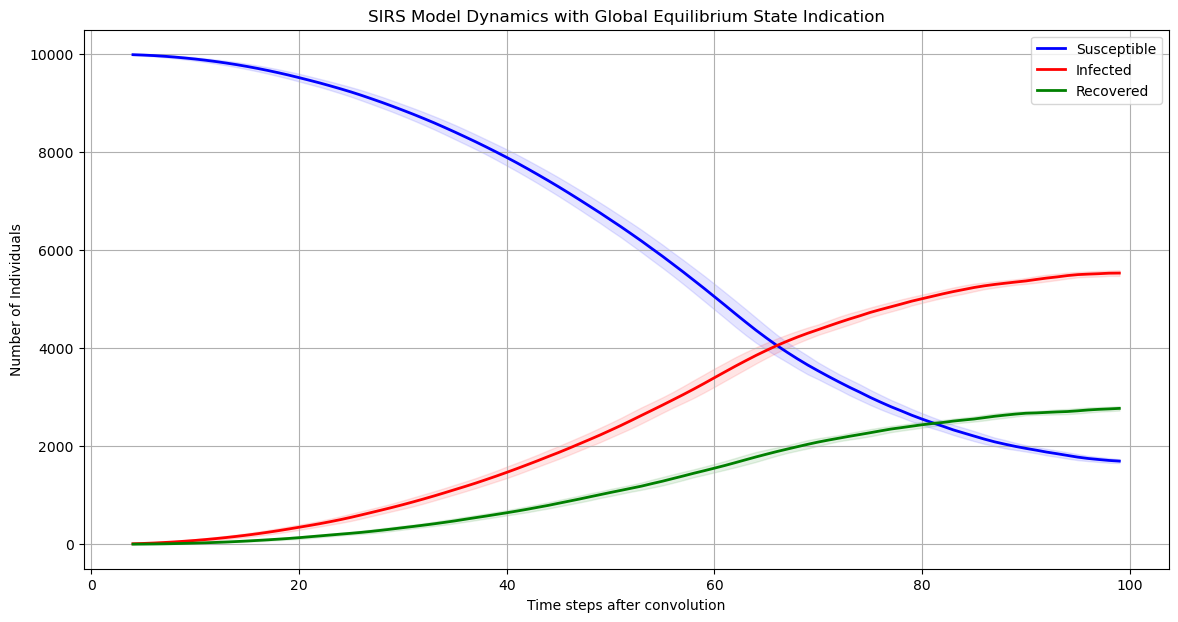

In [87]:
window_size = 5
threshold = 0.01
consecutive_steps_for_equilibrium = 10

# Calculate global moving averages and standard deviations across all simulations
global_moving_avg_S = np.zeros(num_steps - window_size + 1)
global_moving_avg_I = np.zeros(num_steps - window_size + 1)
global_moving_avg_R = np.zeros(num_steps - window_size + 1)
global_moving_std_S = np.zeros(num_steps - window_size + 1)
global_moving_std_I = np.zeros(num_steps - window_size + 1)
global_moving_std_R = np.zeros(num_steps - window_size + 1)

for step in range(window_size - 1, num_steps):
    # Slice to get the windowed data across all simulations for this time step
    windowed_S = all_S[:, step-window_size+1:step+1]
    windowed_I = all_I[:, step-window_size+1:step+1]
    windowed_R = all_R[:, step-window_size+1:step+1]

    # Calculate the means and standard deviations for the window
    global_moving_avg_S[step-window_size+1] = np.mean(windowed_S)
    global_moving_avg_I[step-window_size+1] = np.mean(windowed_I)
    global_moving_avg_R[step-window_size+1] = np.mean(windowed_R)
    global_moving_std_S[step-window_size+1] = np.std(windowed_S)
    global_moving_std_I[step-window_size+1] = np.std(windowed_I)
    global_moving_std_R[step-window_size+1] = np.std(windowed_R)

# Checking equilibrium condition
for i in range(1, len(global_moving_avg_I)):
    epsilon = 1e-10
    if (np.abs(global_moving_avg_I[i] - global_moving_avg_I[i-1]) / (global_moving_avg_I[i-1] + epsilon) < threshold):
        consecutive_steps_below_threshold += 1
        if consecutive_steps_below_threshold >= consecutive_steps_for_equilibrium:
            equilibrium_step = i + window_size // 2  # Adjust for the window size effect
            break
    else:
        consecutive_steps_below_threshold = 0

# Check if an equilibrium step was found and print mean and std
if equilibrium_step is not None:
    print(f"Equilibrium reached at step {equilibrium_step + window_size}")
    eq_step_index = equilibrium_step - (window_size - 1)
    print(f"Mean and std at equilibrium (step {equilibrium_step + window_size}):")
else:
    print("Equilibrium state was not reached within the given time frame")
    eq_step_index = -1  # Use the last step's index
    print(f"Mean and std at the last step ({num_steps}):")

# Print global means and standard deviations at equilibrium or the last step
print(f"Mean S: {global_moving_avg_S[eq_step_index]:.2f}, Std S: {global_moving_std_S[eq_step_index]:.2f}")
print(f"Mean I: {global_moving_avg_I[eq_step_index]:.2f}, Std I: {global_moving_std_I[eq_step_index]:.2f}")
print(f"Mean R: {global_moving_avg_R[eq_step_index]:.2f}, Std R: {global_moving_std_R[eq_step_index]:.2f}")

# Plotting with shaded areas for standard deviation
time_steps = np.arange(window_size - 1, num_steps)

plt.figure(figsize=(14, 7))

plt.fill_between(time_steps, global_moving_avg_S - global_moving_std_S, global_moving_avg_S + global_moving_std_S, color='blue', alpha=0.1)
plt.fill_between(time_steps, global_moving_avg_I - global_moving_std_I, global_moving_avg_I + global_moving_std_I, color='red', alpha=0.1)
plt.fill_between(time_steps, global_moving_avg_R - global_moving_std_R, global_moving_avg_R + global_moving_std_R, color='green', alpha=0.1)

plt.plot(time_steps, global_moving_avg_S, label='Susceptible', color='blue', linewidth=2)
plt.plot(time_steps, global_moving_avg_I, label='Infected', color='red', linewidth=2)
plt.plot(time_steps, global_moving_avg_R, label='Recovered', color='green', linewidth=2)

plt.xlabel('Time steps after convolution')
plt.ylabel('Number of Individuals')
plt.title('SIRS Model Dynamics with Global Equilibrium State Indication')
plt.legend()
plt.grid(True)
plt.show()

### Analysis Epidemic Dynamics Across Different (γ,β) Configurations On a Grid Network
We aim in this analysis to understand the dynamics of an SIRS epidemic model across various simulations. Each simulation is characterized by a pair of parameters: γ (the recovery rate) and β (the rate at which recovered individuals return to a susceptible state). By keeping the infection rate constant, we observe the changes in the infected population over time solely as functions of γ and β
* Each (γ,β) configuration will have its dedicated plot and data set for clarity and ease of comparison.

In [2]:
number_of_workers = os.cpu_count() // 2
print(number_of_workers)
with Pool(number_of_workers) as pool:  # Use 7 of my 8 logical processors
    results = pool.map(run_simulation, gamma_beta_pairs)

4


In [9]:
@jit(nopython=True)
def run_simulation(num_steps, grid, delta, gamma, beta):
    infected_counts = np.zeros(num_steps)
    for step in range(num_steps):
        infected_counts[step] = np.count_nonzero(grid == 0)
        grid = simulate_epidemic_step(grid, delta, gamma, beta, 'SIRS')
    return infected_counts

In [11]:
gamma_beta_pairs = [(gamma, beta) for gamma in np.arange(0, 1.1, 0.1) 
                                   for beta in np.arange(0, 1.1, 0.1)]

# Run simulations and plot results
for gamma, beta in gamma_beta_pairs:
    simulation_results = np.zeros((num_simulations, num_steps))
    for simulation in range(num_simulations):
        grid_copy = np.copy(grid)  # Reset grid for each simulation
        simulation_results[simulation] = run_simulation(num_steps, grid_copy, delta, gamma, beta)

    # Plotting individual simulation lines
    plt.figure(figsize=(10, 5))
    for sim in range(simulation_results.shape[0]):
        plt.plot(simulation_results[sim, :], label=f'Simulation {sim+1}')
    
    plt.title(f'Simulation Series for γ={gamma:.1f}, β={beta:.1f}')
    plt.xlabel('Step')
    plt.ylabel('Infected Individuals')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.savefig(f'C:\\Users\\ubci\\OneDrive\\Bureau\\ProjetDeBachelor\\Simulation_series_Gamma_Beta\\simulation_series_gamma{gamma:.1f}_beta{beta:.1f}.png', bbox_inches='tight')
    plt.close()

    # Data Storage
    df = pd.DataFrame(simulation_results)
    df.to_csv(f'C:\\Users\\ubci\\OneDrive\\Bureau\\ProjetDeBachelor\\Simulation_data_Gamma_Beta\\simulation_data_gamma{gamma:.1f}_beta{beta:.1f}.csv', index=False)

In this section, we embark on a comprehensive analysis of the SIRS model across a spectrum of recovery rates (γ) and reinfection rates (β). Our simulations, encapsulated within a multi-parametric study, aim to discern patterns in the spread of infection over a predefined grid population. The essence of this analysis is to comprehend how these rates affect the state of the system, categorized into distinct behavioral regimes.

We have generated a suite of simulations for each pair of (γ,β), holding the infection rate (δ) constant. This approach allows us to observe the system's behavior solely as a function of recovery and reinfection dynamics. The outcomes of these simulations are crucial in understanding the conditions under which an infection may become endemic, be eradicated, or exhibit cyclical patterns.

To achieve this, we will proceed through the following steps:
* **Load and Aggregate Data:** For each (γ,β) pair, we will load the saved simulation data and compute the average infection level over time across all corresponding simulations.
* **Categorization:** Based on predetermined thresholds, we will categorize the epidemic outcome into three distinct types:
    * *All nodes are infected:* A high proportion of the grid becomes infected at some point in the simulation, indicating the potential for endemic infection.
    * *Infection ends:* The infection dies out before spreading significantly, suggesting conditions favorable for the eradication of the disease.
    * *Oscillation:* The number of infected individuals fluctuates without stabilizing, which could indicate complex dynamics such as seasonal effects or incomplete immunity.
* **Visualization:** We will create a phase diagram mapping each (γ,β) pair to its categorized behavior, color-coded for clarity. This visualization will provide a bird's-eye view of our model's dynamics under varying conditions.

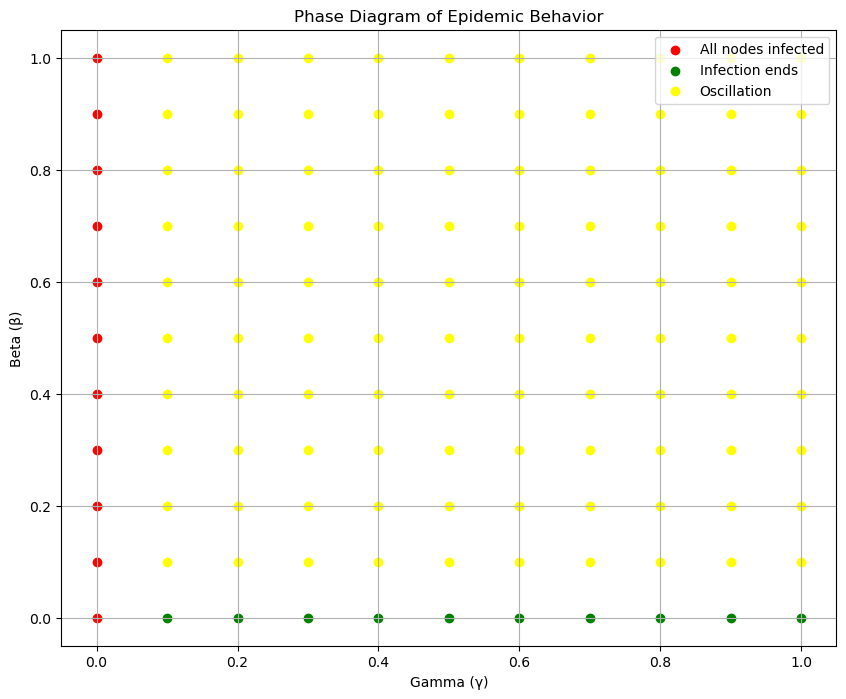

In [12]:
# Define the directory where the simulation data is stored
data_directory = "C:\\Users\\ubci\\OneDrive\\Bureau\\ProjetDeBachelor\\Simulation_data_Gamma_Beta"

total_nodes = width * height

# Prepare a list for the categorization of each pair
categorized_results = []

# Threshold for deciding categories
threshold = 0.80 * num_simulations  # 80% of all simulations are taken in the account (we allow 3 of 15)

# Iterate over all the (γ, β) pairs
for filename in os.listdir(data_directory):
    filepath = os.path.join(data_directory, filename)
    df = pd.read_csv(filepath)

    simulation_col = []
    
    for array_sim in np.asarray(df) :
        # Take the last element of each simulation array
        simulation_col.append(array_sim[-1])
        
    # Determine categories for each simulation and classify based on the majority condition
    if simulation_col.count(total_nodes) >= threshold:
        category = 'All nodes infected'
    elif simulation_col.count(0.0) >= threshold:
        category = 'Infection ends'
    else:
        category = 'Oscillation'
        
    # Extract γ, β from filename (assuming naming convention used earlier)
    gamma_beta = filename.replace('simulation_data_gamma', '').replace('beta', '').replace('.csv', '')
    gamma, beta = map(float, gamma_beta.split('_'))
        
    categorized_results.append((gamma, beta, category))

# Convert to DataFrame for easier analysis
categorized_df = pd.DataFrame(categorized_results, columns=['gamma', 'beta', 'category'])

# Plotting the categorized results
colors = {'All nodes infected': 'red', 'Infection ends': 'green', 'Oscillation': 'yellow'}

plt.figure(figsize=(10, 8))
for category, color in colors.items():
    subset = categorized_df[categorized_df['category'] == category]
    plt.scatter(subset['gamma'], subset['beta'], color=color, label=category)

plt.xlabel('Gamma (γ)')
plt.ylabel('Beta (β)')
plt.title('Phase Diagram of Epidemic Behavior')
plt.legend()
plt.grid(True)
plt.show()

### Interactive SIRS Model Simulation

This interactive simulation allows you to set the initial number of infected nodes and their locations on a 100x100 grid. You can start the simulation and observe the SIRS process in action. You can stop the simulation at any point by pressing the 'Stop' button.

Use the sliders to choose the initial number of infected nodes and their positions. Then, press 'Start' to begin the simulation and 'Stop' to end it. The simulation will run step by step, updating the grid to show the progression of the infection.

In [57]:
import tkinter as tk
from tkinter import ttk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2Tk
from tkinter import simpledialog, messagebox

In [58]:
width, height = 100, 100

In [59]:
def select_boundary_condition(root):
    """
    Asks the user to select a boundary condition through a simple dialog and hides the main window during the selection.

    Parameters:
    - root: The main Tkinter window.

    Returns:
    - A string representing the chosen boundary condition ('fixed' or 'non_fixed').
    """
    root.withdraw()  # Hide the main window
    options = ["Fixed Boundaries", "Non Fixed Boundaries"]
    choice = simpledialog.askstring("Boundary Condition Selection",
                                    "Select Boundary Condition:\n1. Fixed Boundaries\n2. Non Fixed Boundaries",
                                    parent=root)  # Ensure the dialog is modal to the root window

    # Process the user's choice
    if choice is not None:  # Check if the user didn't just close the dialog
        choice = choice.lower()
        if "1" in choice or "fixed" in choice:
            root.deiconify()  # Show the main window again
            return "fixed"
        elif "2" in choice or "non" in choice:
            root.deiconify()  # Show the main window again
            return "non_fixed"
    
    # If the choice is None (dialog closed) or an invalid selection, show an error and exit
    messagebox.showerror("Invalid Selection", "Please restart and select a valid option.", parent=root)
    root.destroy()
    exit()

In [60]:
def select_model(root):
    """
    Asks the user to select an epidemic model (SIR, SIS, or SIRS) through a simple dialog and hides the main window during the selection.

    Parameters:
    - root: The main Tkinter window.

    Returns:
    - A string representing the chosen model ('SIR', 'SIS', or 'SIRS').
    """
    root.withdraw()  # Hide the main window temporarily
    model = simpledialog.askstring("Model Selection",
                                   "Select Epidemic Model:\n1. SIR\n2. SIS\n3. SIRS",
                                   parent=root)

    # Process the user's choice
    if model is not None:  # Check if the user didn't just close the dialog
        model = model.lower()
        if "1" in model or "sir" in model:
            root.deiconify()  # Show the main window again
            return "SIR"
        elif "2" in model or "sis" in model:
            root.deiconify()  # Show the main window again
            return "SIS"
        elif "3" in model or "sirs" in model:
            root.deiconify()  # Show the main window again
            return "SIRS"

    # If the choice is None (dialog closed) or an invalid selection
    messagebox.showerror("Invalid Selection", "Please restart and select a valid option.", parent=root)
    root.destroy()
    exit()

Real infection source node set at: (5, 2)


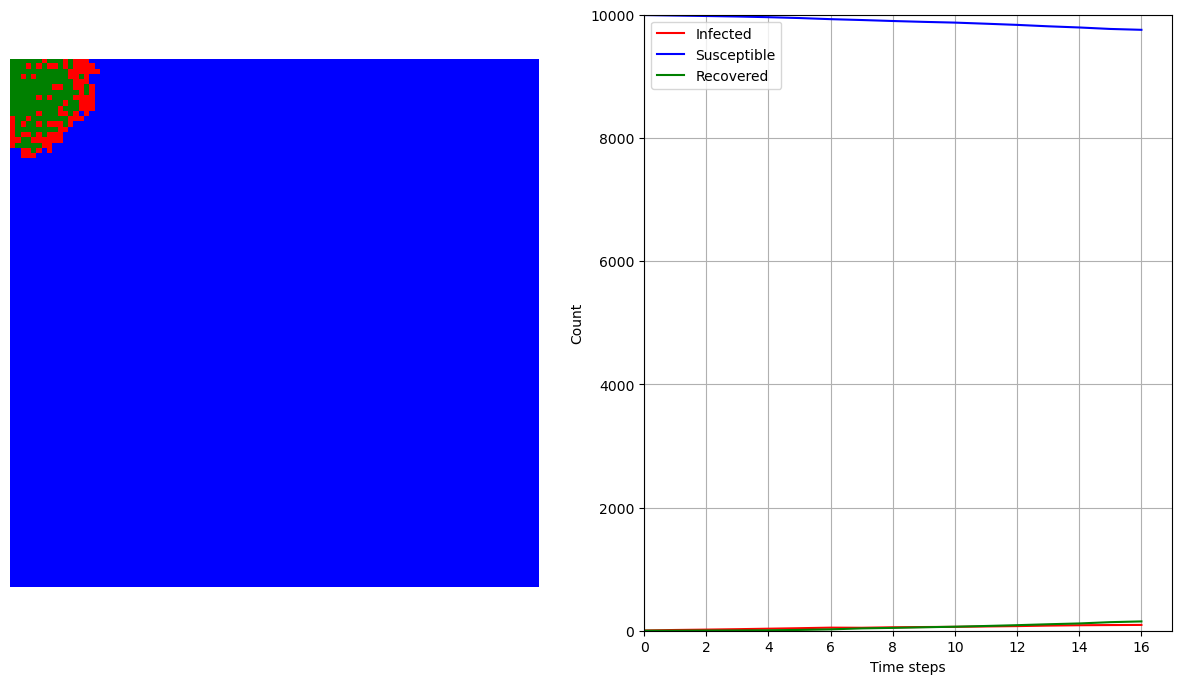

In [101]:
delta, gamma, beta = 0.7, 0.2, 0.4

cmap, norm = colors_grid()

window_size = 100  # Check the last 100 steps for equilibrium
threshold = 60    # Define the maximum allowed standard deviation
equilibrium_reached = False
grid = np.full((width, height), -1)  
running = False
current_step = 0
infected_counts, susceptible_counts, recovered_counts = [], [], []

# Setup the Tkinter window
root = tk.Tk()
root.title('SIRS Simulation Game')
boundary_condition = select_boundary_condition(root)
model = select_model(root)

# Function to update the equilibrium message
def display_equilibrium_message():
    equilibrium_label.config(text=f"Equilibrium state reached at step {current_step-80}!")

# Function to check for equilibrium state
def check_for_equilibrium(infected_counts):
    if len(infected_counts) >= window_size:
        # Check the last few entries for changes
        recent_counts = infected_counts[-window_size:]
        std_deviation = np.std(recent_counts)
        
        if std_deviation < threshold:
            return True # Equilibrium state detected
    return False

# Function to update the grid plot and infection curve
def update_plot():
    global current_step, infected_counts, susceptible_counts, recovered_counts

    ax_grid.clear()
    ax_infected.clear()
    ax_grid.imshow(grid, cmap=cmap, norm=norm, aspect='equal')
    ax_grid.axis('off')

    ax_infected.plot(infected_counts, 'r-', label='Infected')
    ax_infected.plot(susceptible_counts, 'b-', label='Susceptible')
    ax_infected.plot(recovered_counts, 'g-', label='Recovered')
    ax_infected.set_xlim(0, max(1, current_step))
    ax_infected.set_ylim(0, width*height)
    ax_infected.set_xlabel('Time steps')
    ax_infected.set_ylabel('Count')
    ax_infected.legend()
    ax_infected.grid(True)

    step_label.config(text=f"Step: {current_step}")  # Update the step label here

    canvas.draw()

# Simulation step function
def simulation_step():
    global running, grid, current_step, infected_counts, susceptible_counts, recovered_counts, equilibrium_reached, boundary_condition, model
    if running:
        current_step += 1  # Increment the step counter
        grid = simulate_epidemic_step(grid, delta_slider.get(), gamma_slider.get(), beta_slider.get(), boundary_condition, model)

        infected_counts.append(np.count_nonzero(grid == 0))
        susceptible_counts.append(np.count_nonzero(grid == -1))
        recovered_counts.append(np.count_nonzero(grid == 1))

        # Check for equilibrium state after updating counts 
        if not equilibrium_reached and check_for_equilibrium(infected_counts):
            # Stop the simulation
            stop_simulation()
            messagebox.showinfo(
                    "Equilibrium State",
                    f"Equilibrium reached!\nInfected: {infected_counts[-1]}"
                    f"\nSusceptible: {susceptible_counts[-1]}"
                    f"\nRecovered: {recovered_counts[-1]}"
                )
            equilibrium_reached = True
            display_equilibrium_message()
            
            
        update_plot()  # Update plots

        # Continue the simulation
        root.after(1, simulation_step)

def start_simulation():
    global running
    running = True
    status_label.config(text="Running")
    simulation_step()

def stop_simulation():
    global running
    status_label.config(text="Stopped")
    running = False

def reset_simulation():
    global running, current_step, grid, infected_counts, susceptible_counts, recovered_counts, equilibrium_reached, boundary_condition, model
    running = False
    current_step = 0
    grid = np.full((width, height), -1)
    infected_counts, susceptible_counts, recovered_counts = [], [], []
    status_label.config(text="Ready")
    equilibrium_label.config(text="")
    equilibrium_reached = False
    update_plot()
    boundary_condition = select_boundary_condition(root) # select boundary condition again
    model = select_model(root) # select model again

# Callback function for clicking on the grid
def on_click(event):
    if event.xdata is not None and event.ydata is not None:
        i, j = int(event.ydata), int(event.xdata)
        grid[i, j] = 0
        print(f"Real infection source node set at: ({i}, {j})")
        update_plot()

# Slider update function
def update_labels(value):
    delta_label.config(text=f"Delta: {delta_slider.get():.2f}")
    gamma_label.config(text=f"Gamma: {gamma_slider.get():.2f}")
    beta_label.config(text=f"Beta: {beta_slider.get():.2f}")

# Set up the controls frame with sliders and buttons
controls_frame = ttk.Frame(root)
controls_frame.pack(side='top', fill='x', expand=True)

# sliders 
delta_slider = ttk.Scale(controls_frame, from_=0, to=1, orient='horizontal', value=delta, command=update_labels)
gamma_slider = ttk.Scale(controls_frame, from_=0, to=1, orient='horizontal', value=gamma, command=update_labels)
beta_slider = ttk.Scale(controls_frame, from_=0, to=1, orient='horizontal', value=beta, command=update_labels)
# labels
delta_label = ttk.Label(controls_frame, text=f"Delta: {delta:.2f}")
gamma_label = ttk.Label(controls_frame, text=f"Gamma: {gamma:.2f}")
beta_label = ttk.Label(controls_frame, text=f"Beta: {beta:.2f}")
step_label = ttk.Label(controls_frame, text="Step: 0")
# buttons
start_button = ttk.Button(controls_frame, text='Start', command=start_simulation)
stop_button = ttk.Button(controls_frame, text='Stop', command=stop_simulation)
reset_button = ttk.Button(controls_frame, text='Reset', command=reset_simulation)
# Pack the sliders, the labels, and the buttons
for widget in [delta_slider, gamma_slider, beta_slider, delta_label, gamma_label, beta_label, step_label, start_button, stop_button, reset_button]:
    widget.pack(side='left', padx=10)

# Set up the matplotlib figure and axes
fig, (ax_grid, ax_infected) = plt.subplots(1, 2, figsize=(15, 8))  # Two subplots: one for the grid, one for the infection curve

# Setup the canvas and toolbar
canvas = FigureCanvasTkAgg(fig, master=root)
canvas.mpl_connect('button_press_event', on_click)  # Connect the on_click function
canvas_widget = canvas.get_tk_widget()
canvas_widget.pack(side='bottom', fill='both', expand=True)

# status label
status_label = ttk.Label(root, text="Ready", foreground="blue")
status_label.pack(side='top', pady=10)

# equilibrium label
equilibrium_label = ttk.Label(root, text="", foreground="red")
equilibrium_label.pack(side='top', pady=10)

# Initialize the grid plot
ax_grid.imshow(grid, cmap=cmap, norm=norm, aspect='equal')

# Initialize the infection plot
infected_counts = [0] * current_step
(line,) = ax_infected.plot(range(current_step), infected_counts, 'r-')

# Add the navigation toolbar
toolbar = NavigationToolbar2Tk(canvas, root)
toolbar.update()

# Initial plot update
update_plot()

# Start the Tkinter main loop
root.mainloop()

In [9]:
import heapq

In [10]:
print(boundary_condition)
print(model)

fixed
SIR


In [89]:
@jit(nopython=True)
def get_neighbors(i, j, width, height, boundary_condition):
    """Get neighbors, taking into account the boundary condition."""
    neighbors = np.empty((4, 2), dtype=np.int64)
    count = 0

    if boundary_condition == 'fixed':
        # Check each direction and add neighbor if within grid boundaries
        if i > 0:
            neighbors[count] = (i - 1, j)
            count += 1
        if i < height - 1:
            neighbors[count] = (i + 1, j)
            count += 1
        if j > 0:
            neighbors[count] = (i, j - 1)
            count += 1
        if j < width - 1:
            neighbors[count] = (i, j + 1)
            count += 1
        
    else:
        # For non-fixed boundaries, all cells have four neighbors (wraparound)
        neighbors[0] = ((i - 1) % height, j)
        neighbors[1] = ((i + 1) % height, j)
        neighbors[2] = (i, (j - 1) % width)
        neighbors[3] = (i, (j + 1) % width)
        count = 4  # All four neighbors are populated

    # Return only the populated part of the neighbors array
    return neighbors[:count]

In [90]:
@jit(nopython=True)
def infection_nodes(grid):
    width, height = grid.shape
    # Create an empty array to store the infection status
    infected_status = np.zeros((height, width), dtype=np.int64)
    
    # Iterate over each cell in the grid
    for i in range(height):
        for j in range(width):
            # Check current node infection status
            if grid[i, j] == 0:
                infected_status[i, j] = 1  # Node is currently infected
                continue
            
            # Check if any neighbor is infected for susceptible nodes
            if grid[i, j] == -1:
                if i > 0 and grid[i-1, j] == 0:
                    infected_status[i, j] = 1  # North neighbor
                elif i < height - 1 and grid[i+1, j] == 0:
                    infected_status[i, j] = 1  # South neighbor
                elif j > 0 and grid[i, j-1] == 0:
                    infected_status[i, j] = 1  # West neighbor
                elif j < width - 1 and grid[i, j+1] == 0:
                    infected_status[i, j] = 1  # East neighbor
    
    # Return the indices where infected_status is 1 (either currently infected or was infected)
    return np.argwhere(infected_status == 1)

* **Complete Observation:** would mean having a view of the entire history of the spread from the initial infection to the current state.
* **Snapshot:** a single picture at a specific time point that shows the state of all nodes at that moment.

To identifiy the source node, I'm looking at a **snapshot** of the grid at a given time step where each cell represents a node that can be in one of two or three states: Susceptible or Infected if the model is **SIS** or susceptible, Infected or recovered if the model is **SIR** or **SIRS**. 

Let's use the **Jordan center** of a graph, which is a node (or nodes) such that the *maximum distance to any other node in the graph is minimized*.

However, I made these assumptions:

* The spread of infection is uniform and at a constant rate.
* The network structure does not change over time.
* The infection spread does not include randomness or variability in transmission rates.

1) I'm using ***Dijkstra's algorithm*** to compute the *shortest distances* between all pairs of nodes (which in this case, translates to the *minimum number of steps* required for the infection to travel from one node to another)
2) For each node **V**, I'm finding **Vm**, which is the longest shortest path from **V** to to any other node (in other words, I'm finding the* maximum distanc*e that the infection would have to travel from **V** to reach the furthest point in the grid.
3) I'm supposing that the source node will be one of the nodes with the smallest **Vm** (it's centrally located with respect to the spread of the infection -> It's the **Jordan Center**) -> I chose this node because it would take the least amount of time for the infection to reach all other nodes from there, since the infection spreads at a constant rate (it would have taken the same amount of time to reach the farthest points).

This idea is good for **SIR** models with *fixed grid* if the infection is yet to reach boundary nodes, or *non-fixed* grid.

In [15]:
def dijkstra(grid, start_pos, boundary_condition, model, infected_nodes):
    width, height = grid.shape
    visited = set()
    distances = {start_pos: 0}
    pq = [(0, start_pos)]  # Priority queue: distance, position

    while pq:
        dist, (x,y) = heapq.heappop(pq)

        if (x, y) in visited:
            continue
        visited.add((x, y))

        neighbors = get_neighbors(x, y, width, height, boundary_condition)
        for nx, ny in neighbors:
            if model == 'SIR' and grid[nx, ny] not in [0, 1]:
                continue  # Skip non-infected/non-recovered nodes for SIR
            if model in ['SIS', 'SIRS'] and (nx, ny) not in infected_nodes:
                continue  # Skip nodes that are not part of the infection process for SIS/SIRS
            
            new_dist = dist + 1
            if (nx, ny) not in distances or new_dist < distances[(nx, ny)]:
                distances[(nx, ny)] = new_dist
                heapq.heappush(pq, (new_dist, (nx, ny)))

    return distances

### BFS

In [91]:
from collections import deque
import time

In [98]:
def bfs(grid, start_pos, boundary_condition, model, infected_nodes):
    width, height = grid.shape
    visited = np.zeros_like(grid, dtype=np.int64)  # 0 unvisited, 1 visited
    distances = np.full_like(grid, -1, dtype=np.int64)  # -1 for unreachable nodes
    queue = deque()
    queue.append(start_pos)

    visited[start_pos] = 1
    distances[start_pos] = 0

    while queue:
        x, y = queue.popleft()
        
        for nx, ny in get_neighbors(x, y, width, height, boundary_condition):
            if visited[nx, ny] == 0 and ((model == 'SIR' and grid[nx, ny] in [0, 1]) or (model in ['SIS', 'SIRS'] and (nx, ny) in infected_nodes)):
                visited[nx, ny] = 1
                distances[nx, ny] = distances[x, y] + 1
                queue.append((nx, ny))

    return distances

In [93]:
def find_infection_source(grid, boundary_condition, model):
    height, width = grid.shape
    
    candidate_nodes = []
    if model == "SIR":
        # For SIR, consider both infected and recovered nodes as candidates
        candidate_nodes = np.argwhere((grid == 0) | (grid == 1))
    else:
        # For SIS and SIRS, consider nodes that are infected or were infected
        candidate_nodes = infection_nodes(grid)

    centrality_scores = np.zeros_like(grid, dtype=np.float32)

    global_start_time = time.time()
    for i, start_pos in enumerate(candidate_nodes):
        start_time = time.time()
        start_pos_tuple = tuple(start_pos)
        
        # Pass the precomputed infected nodes if applicable
        distances = dijkstra(grid, start_pos_tuple, boundary_condition, model, candidate_nodes)

        # Compute centrality score considering distances to other nodes
        total_distance = sum(distances.values())
        num_reachable_nodes = len(distances) - 1  # Exclude the start node itself
        if num_reachable_nodes > 0:
            average_distance = total_distance / num_reachable_nodes
            centrality_scores[start_pos_tuple] = 1 / average_distance
        else:
            centrality_scores[start_pos_tuple] = 0

        print("Processed node (%d,%d) took %.2f sec" % (start_pos[0], start_pos[1], time.time() - start_time), end='\r')

    # Find the node with the highest centrality score
    source_node = np.unravel_index(np.argmax(centrality_scores), grid.shape)
    print("Total processing time: %.2f sec" % (time.time() - global_start_time))
    
    return source_node

In [53]:
source_node = find_infection_source(grid, boundary_condition, model)
print("Infection source node with Dijkstra:", source_node)

Total processing time: 107.93 secsec
Infection source node with Dijkstra: (47, 45)


In [99]:
def find_infection_source(grid, boundary_condition, model):
    height, width = grid.shape
    
    candidate_nodes = []
    if model == "SIR":
        # For SIR, consider both infected and recovered nodes as candidates
        candidate_nodes = np.argwhere((grid == 0) | (grid == 1))
    else:
        # For SIS and SIRS, consider nodes that are infected or were infected
        candidate_nodes = infection_nodes(grid)

    centrality_scores = np.zeros_like(grid, dtype=np.float32)

    global_start_time = time.time()
    for i, start_pos in enumerate(candidate_nodes):
        start_time = time.time()
        start_pos_tuple = tuple(start_pos)
        
        # Pass the precomputed infected nodes if applicable
        distances = bfs(grid, start_pos_tuple, boundary_condition, model, candidate_nodes)

        # Compute centrality score considering distances to other nodes
        reachable_nodes = distances[distances != -1]  # Exclude unreachable nodes
        num_reachable_nodes = len(reachable_nodes) - 1  # Exclude the start node itself
        total_distance = np.sum(reachable_nodes)
        
        if num_reachable_nodes > 0:
            average_distance = total_distance / num_reachable_nodes
            centrality_scores[start_pos_tuple] = 1 / average_distance
        else:
            centrality_scores[start_pos_tuple] = 0

        print("Processed node (%d,%d) took %.2f sec" % (start_pos[0], start_pos[1], time.time() - start_time), end='\r')

    # Find the node with the highest centrality score
    source_node = np.unravel_index(np.argmax(centrality_scores), grid.shape)
    print("Total processing time: %.2f sec" % (time.time() - global_start_time))
    
    return source_node

In [102]:
source_node = find_infection_source(grid, boundary_condition, model)
print("Infection source node with DFS:", source_node)

Total processing time: 2.76 sec secc
Infection source node with DFS: (7, 6)


## Investigating Epidemic Spread in Tree Structures

In this section, we will explore how an infectious process spreads within tree structures. Trees are a type of graph consisting of nodes and edges where any two vertices are connected by exactly one path (avoiding the complexities introduced by *cycles* and *multiple paths*).

The spread of infection in tree structures is crucial since it brings:

* **Simplicity:** Trees allow for clearer analytical insights into the dynamics of the spread due to their simple structure.
* **Hierarchical Spread Modeling:** Many real-world systems (organizational structures, family trees, and certain types of communication networks) naturally follow a tree-like hierarchy.

We will simulate an SIRS epidemic model on various tree graphs. The focus will be on observing how the infection spreads through the tree over time, the impact of various parameters on the spread, and the time it takes for the infection to reach different parts of the tree.

Objectives:

* **Generate Tree Structures:** Utilize different tree generation techniques to create models for our simulations.

* **Analyze Spread Dynamics:** Investigate the role of tree depth, branching factor, and model parameters (infection rate, recovery rate, and loss of immunity rate) in the spread dynamics.
Visualize Outcomes: Use plots and animations to visualize the spread of infection over time across the tree structure.

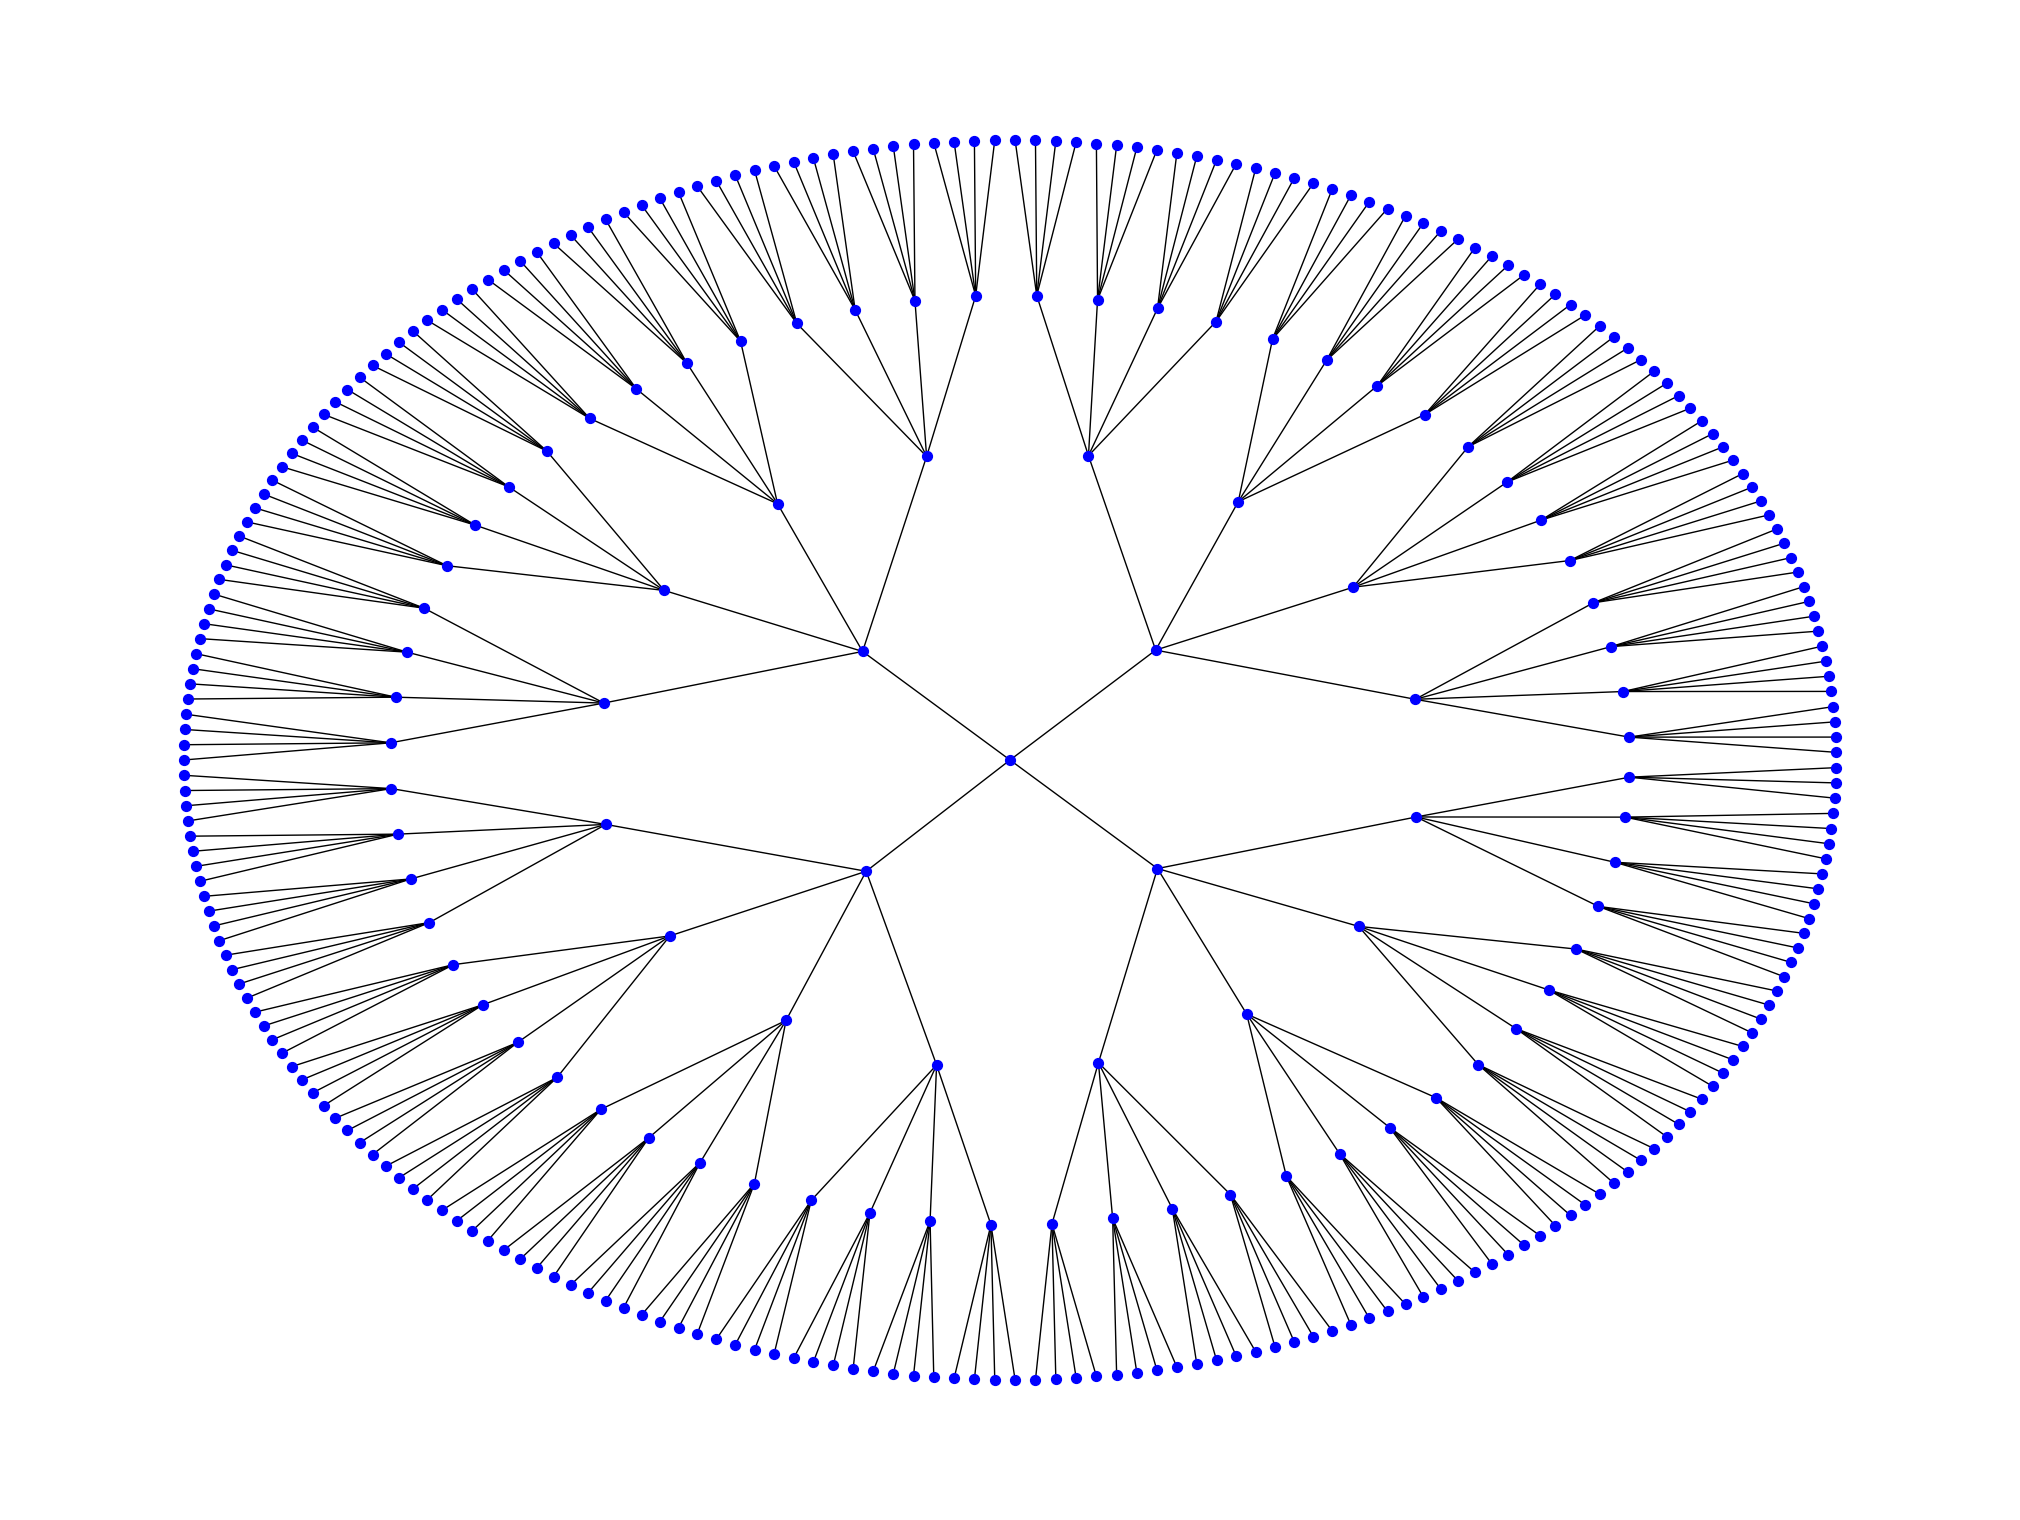

In [63]:
# Parameters for the tree
num_vertices = 340  # Target number of vertices in the tree
children_count = 4  # Branching factor

# Calculate the necessary height to get close to the desired number of vertices
height = 1
while True:
    num_nodes = (children_count**(height + 1) - 1) // (children_count - 1)
    if num_nodes >= num_vertices:
        break
    height += 1

# Generate the tree using the calculated height
tree = nx.balanced_tree(children_count, height, create_using=nx.DiGraph())

# Trim the tree to get exactly num_vertices nodes
if len(tree) > num_vertices:
    nodes_to_remove = len(tree) - target_num_vertices
    tree.remove_nodes_from(sorted(tree.nodes())[-nodes_to_remove:])

# Generate layout for the tree
pos = nx.drawing.nx_agraph.graphviz_layout(tree, prog="twopi")

# Visualization
plt.figure(figsize=(20, 15))  # Adjust figure size for clarity
nx.draw(tree, pos, with_labels=False, node_size=50, node_color="blue", arrows=False)
plt.axis('off')  # Hide axes for cleaner visualization
plt.show()